In [1]:
import random
import numpy as np
import pandas as pd
from os.path import join as pjoin
from itertools import product, combinations
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib import colors
from numpy import random
import scipy
from scipy import stats
from utils import goinfo_create_fit, oinfo_min, goinfo_create_fit_correction
import os.path as op
from frites.workflow import WfStats
import mne
import xarray as xr
from frites.utils import parallel_func

import hoi
#import xgi
import xarray as xr
import warnings 
import scipy.io

path="C:/Users/matte/Codes/"

## uploading the data


In [9]:
meg_data_action_learning=scipy.io.loadmat(path+"data/meg_visuomotor/learning/meg_data_action.mat")
colinmars_struc_matrix_96=scipy.io.loadmat(path+"data/meg_visuomotor/sc_marsAtlas/colinmars_struc_matrix_96.mat")

In [10]:
meg_data_action_mapping=scipy.io.loadmat(path+"data/meg_visuomotor/mapping/meg_data_action.mat")


In [11]:
meg_data_action_mapping['data'].shape

(1078, 96, 600)

In [15]:
index_learning=np.where(meg_data_action_learning['learning']<7)[0]


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

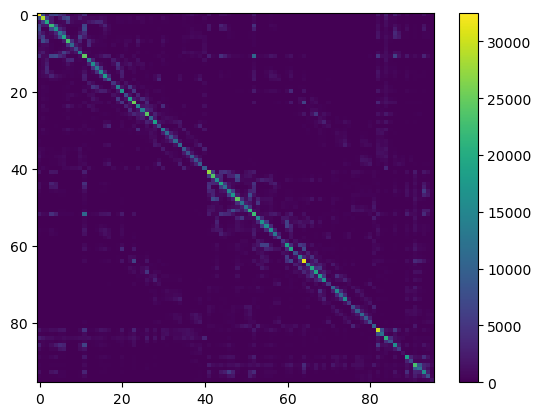

In [37]:
plt.imshow(colinmars_struc_matrix_96['mat'], aspect='auto')
plt.colorbar()

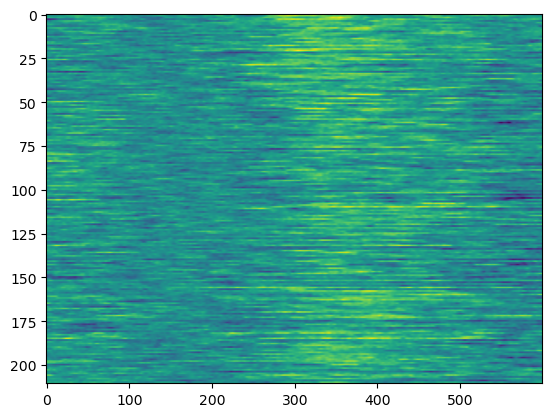

In [28]:
plt.imshow(meg_data_action['data'][np.where(meg_data_action['subject']==1)[0],0,:], aspect='auto')

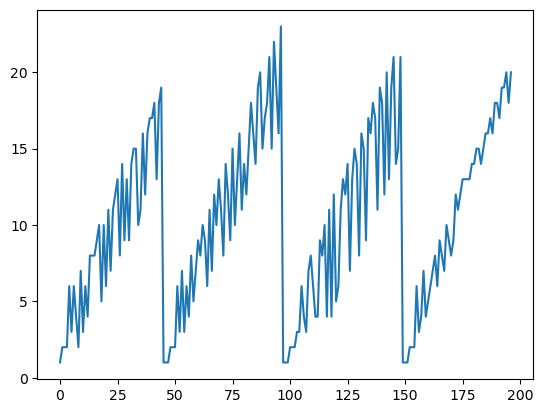

In [4]:
plt.plot(meg_data_action['learning'][np.where(meg_data_action['subject']==3)[0]])

In [72]:
isub=1
data_brain=meg_data_action['data'][np.where(meg_data_action['subject']==isub)[0],:,:]
beh=meg_data_action['learning'][np.where(meg_data_action['subject']==isub)[0]]

n_trials, n_roi, n_times = data_brain.shape

list_roi=[f"R{r+1}" for r in range(n_roi)]

roi = np.array(list_roi)
trials = np.arange(n_trials)
times = np.arange(n_times)

maxsize=3
minsize=2


model = hoi.metrics.GradientOinfo(data_brain, beh)
goinfo = model.fit(minsize=minsize, maxsize=maxsize)



    Copnorm data
Get list of multiplets


  0%|          |  0/2 [00:00<?,       ?it/s]

    Copnorm data
Get list of multiplets


  0%|          |  0/2 [00:00<?,       ?it/s]

In [49]:
combos=model.get_combinations(minsize=minsize, maxsize=maxsize)[0]

list_indices=[[int(c) for c in comb if c != -1] for comb in combos]

list_multiplets=[str([int(i) for i in comb]) for comb in list_indices]

Get list of multiplets


## Plotting O-info

In [59]:
#goinfo_preproc=oinfo_min(goinfo, list_indices, minsize=2)
   
goinfo_preproc=goinfo

TypeError: Dimensions of C (0, 600) should be one smaller than X(100) and Y(0) while using shading='flat' see help(pcolormesh)

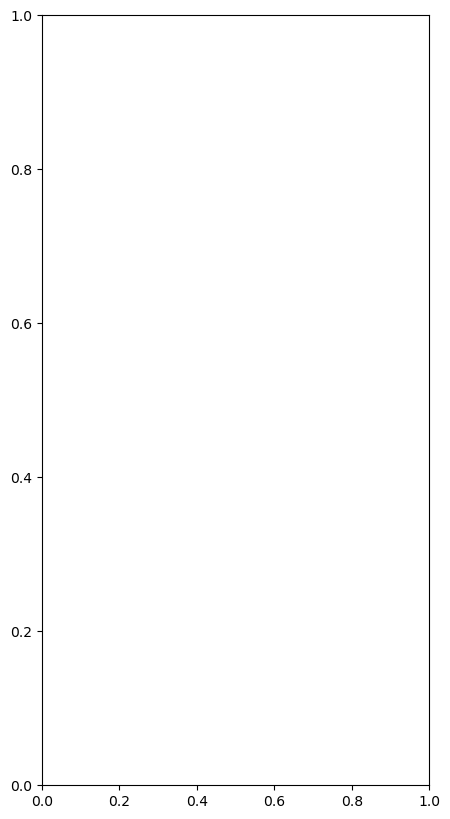

In [66]:
vmin, vmax = -0.2,0.2
minmax = max(abs(vmin), abs(vmax))
vmin, vmax = -minmax, minmax

times=np.arange(100)
indices=list(np.where(np.abs(np.sum(goinfo_preproc, axis=1))>0.001)[0])
plt.figure(figsize=(5,10))
plt.pcolormesh(
    times, [tr for i, tr in enumerate(list_multiplets) if i in indices], goinfo_preproc[indices,:], cmap='RdBu_r', vmin=vmin, vmax=vmax
)
plt.colorbar()
plt.xlabel('Times')
plt.axvline(0., color='k')
plt.tight_layout()
plt.savefig('figure_simulations.png', dpi=600)
plt.show()
plt.close()

In [65]:
indices

[]

In [62]:
#preproc on the oinfo


   
vmin, vmax = -0.2,0.2
minmax = max(abs(vmin), abs(vmax))
vmin, vmax = -minmax, minmax

#oin = oinfo - oinfo_without_beh

# plot the results
#df = oinfo.to_pandas()
#df_beh = oinfo.to_pandas()
#df_without_beh = oinfo_without_beh.to_pandas()
#dff =df_beh.values - oinfo_without_beh.values




# the list of indices might be in the form [ ['R1','R2'], ['R2','R3', 'R4'], ['R5', 'R6', 'R7'], ... ]
#oi_array = oinfo_min(dff,list_indices)
   
times=np.arange(100)

plt.figure(figsize=(5,10))
plt.pcolormesh(
    times, list_multiplets, syn, cmap='RdBu_r', vmin=vmin, vmax=vmax
)
plt.colorbar()
plt.xlabel('Times')
plt.axvline(0., color='k')
plt.tight_layout()
plt.savefig('figure_simulations.png', dpi=600)
plt.show()
plt.close()

NameError: name 'syn' is not defined

<Figure size 500x1000 with 0 Axes>

## Statistics, permutation test

To simulate the same situation as in the real scenario, we simulate the data of different subjects and perform our statistical pipeline.

In [ ]:
n_perm=500

goinfo=goinfo_create_fit(data_brain, beh.T, minsize=minsize, maxsize=maxsize)

parallel, p_fun = parallel_func(goinfo_create_fit, n_jobs=-1, total=n_perm)

perm = parallel(p_fun(data_brain, np.random.permutation(beh.T), minsize=minsize, maxsize=maxsize) for n_p in range(n_perm))

perm=np.array(perm)

    Copnorm data
Get list of multiplets
    Copnorm data                                           
Get list of multiplets
 43%|████▎     |  : 216/500 [4:03:36<5:51:01,   74.16s/it] c:\Users\matte\anaconda3\envs\py310\lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
 52%|█████▏    |  : 260/500 [20:02:33<25:32:34,  383.14s/it]

# creating the list for the permutation statistical test

 effect : list
    True effect list of length (n_roi,) composed of arrays each one of
    shape (n_subjects, ..., n_times). Number of subjects per ROI could
    be different

perms : list
    Permutation list of length (n_roi,) composed of arrays each one of
    shape (n_perm, n_subjects, ..., n_times). Number of subjects per
    ROI could be different

inference : {'ffx', 'irfx'}
    Perform either Fixed-effect ('ffx') or Random-effect ('rfx')
    inferences. By default, random-effect is used

mcp : {'cluster', 'maxstat', 'fdr', 'bonferroni', 'nostat', None}
    Method to use for correcting p-values for the multiple comparison
    problem. Use either : 

In [11]:
effect_list=[goinfo[np.newaxis, i,:] for i in range(len(goinfo[:,0]))]
perm_list=[perm[:,np.newaxis, i,:] for i in range(len(goinfo[:,0]))]

In [13]:
inference='ffx'
mcp='cluster'

wf = WfStats()
pv, tv = wf.fit(effect_list, perm_list, inference=inference, mcp=mcp, tail=0)
# Mean II across subjects


Definition of a non-parametric statistical workflow
    Fixed-effect inference (FFX)
    Cluster forming threshold (tail=0; alpha=0.05; tfce=None)
    Inference at cluster-level
    Cluster detection (threshold=0.004834271036088467; tail=0)


In [ ]:
goinfo_toplot=(goinfo*np.where(pv.T<0.05,1,0))[np.where(np.abs(np.sum(goinfo*np.where(pv.T<0.05,1,0), axis=1))>0)[0],:]

plt.figure(figsize=(5,10))
plt.imshow(goinfo_toplot, aspect='auto', interpolation='none', vmax=0.02)
plt.
plt.colorbar()
plt.show()
plt.close()

: 

## Here we perform the statistic analysis at different orders:

In [ ]:
inference='ffx'
mcp='cluster'

for order in np.arange(minsize, maxsize):

    order+=1
    
    effect_list=[syn[np.newaxis, i,:] for i in indices[order]
    perm_list=[perm[:,np.newaxis, i,:] for i in indices[order]
               
    wf = WfStats()
    pv, tv = wf.fit(effect_list, perm_list, inference=inference, mcp=mcp, tail=0)

    # Mean II across subjects

    pv_stats_e

               



In [61]:
np.where(np.sum(GOinfo*np.where(pv.T<0.05,1,0), axis=1)>0)[0]

array([ 40,  41,  45,  85,  86,  90, 121, 122, 126, 149, 150, 154, 170,
       171, 175, 185, 186, 190, 200, 201, 202, 203, 204, 205, 206, 210,
       211, 212, 255, 291, 314, 315, 319, 335, 336, 340, 350, 351, 355,
       365, 366, 367, 368, 369, 370, 371, 375, 376, 377, 406, 407, 411,
       434, 435, 439, 455, 456, 460, 462, 470, 471, 475, 485, 486, 487,
       488, 489, 490, 491, 495, 496, 497, 498, 500, 518, 519, 523, 539,
       540, 544, 554, 555, 559, 569, 570, 571, 572, 573, 574, 575, 579,
       580, 581, 595, 596, 600, 610, 611, 615, 625, 626, 627, 628, 629,
       630, 631, 635, 636, 637, 645, 646, 650, 660, 661, 662, 663, 664,
       665, 666, 670, 671, 672, 680, 681, 682, 683, 684, 685, 686, 690,
       691, 692, 700, 701, 702, 703, 704, 705, 706, 707, 708, 710, 711,
       712], dtype=int64)

In [ ]:
n_perm=200

def syn_create_fit(data_brain, beh, minsize=3, maxsize=4):

    model = hoi.metrics.SynergyMMI(data_brain, beh)
    goinfo = model.fit(minsize=minsize, maxsize=maxsize)
    return goinfo

syn=syn_create_fit(data_brain, beh.T, minsize=3, maxsize=4)

parallel, p_fun = parallel_func(goinfo_create_fit, n_jobs=-1, total=n_perm)

perm = parallel(p_fun(data_brain, np.random.permutation(beh.T), minsize=minsize, maxsize=maxsize) for n_p in range(n_perm))

100%|██████████|  : 200/200 [08:19<00:00,    2.50s/it]


In [ ]:
n_perm = 200
hoi = []
hoi_p = []
minsize=3
maxsize=4

print("Compute task-related HOI redundancy")


for isub in range(5):

    beh = np.random.rand()
    n_trials = 500
    n_roi = 12
    n_times = 30

    data = np.zeros((n_roi, n_trials))

    data[0] =  random.normal(loc=0.0, scale=1.0, size=n_trials)
    data[1] =  random.normal(loc=0.0, scale=1.0, size=n_trials)
    data[2] =  random.normal(loc=0.0, scale=1.0, size=n_trials)

    beh = (data[0] + data[1] + data[2])

    data[3] =  random.normal(loc=0.0, scale=1.0, size=n_trials)
    data[4] =  random.normal(loc=0.0, scale=1.0, size=n_trials)
    data[5] = data[3] + data[4]

    data[6] = beh + .3*random.normal(loc=0.0, scale=1.0, size=n_trials)
    data[7] = beh + .3*random.normal(loc=0.0, scale=1.0, size=n_trials)
    data[8] = beh + .3*random.normal(loc=0.0, scale=1.0, size=n_trials)

    data[9] = random.normal(loc=0.0, scale=1.0, size=n_trials)
    data[10] = data[9] + random.normal(loc=0.0, scale=1.0, size=n_trials)
    data[11] = data[9] + random.normal(loc=0.0, scale=1.0, size=n_trials)

    data = data.T

    data_random=np.broadcast_to(np.random.multivariate_normal(np.zeros(12), np.identity(12), n_trials)[:,:,np.newaxis], (n_trials, n_roi, n_times))

    han = np.broadcast_to(np.hanning(n_times), (n_trials, n_roi, n_times))

    data_brain = np.broadcast_to(data[:,:,np.newaxis], (n_trials, n_roi, n_times))* han + (1-han) * data_random

    list_roi=[f"R{r+1}" for r in range(n_roi)]

    roi = np.array(list_roi)
    trials = np.arange(n_trials)
    times = np.arange(n_times)
    
    x = xr.DataArray(data_brain, dims=('trials', 'roi', 'times'),
                        coords=(trials, roi, times))
    
    print("permutation for synergy")
    
    syn = conn_hoi_syn(x, beh, times='times', roi='roi', minsize=minsize, maxsize=maxsize, verbose=None)

    # append
    hoi += [syn]
    # Permuted Red parallel fn
    parallel, p_fun = parallel_func(conn_hoi_syn, n_jobs=-1, total=n_perm)
    # Compute permutations in parallel
    perm = parallel(p_fun(x, np.random.permutation(beh), times='times', roi='roi', minsize=minsize, maxsize=maxsize, verbose=None) for n_p in range(n_perm))
    perm = np.stack(perm, axis=0)
    # append
    hoi_p += [perm ]
    # Links names (roi)
    links = syn.roi.data


print('now computing the statistics')
n_links=len(links)

hoi1 = np.array_split(np.stack(hoi), n_links, axis=1)
hoi1_p = np.array_split(np.stack(hoi_p), n_links, axis=2)

# Squeeze
hoi_s = [np.squeeze(val) for val in hoi1]
hoi_p_s = [np.squeeze(val) for val in hoi1_p]
# Reshape
hoi_p_s = [np.swapaxes(val, 0, 1) for val in hoi_p_s]


print("    Compute statistics")

inference='rfx'
mcp='cluster'

wf = WfStats()
pv, tv = wf.fit(hoi_s, hoi_p_s, inference=inference, mcp=mcp, tail=1)
# Mean II across subjects
hoi_m = np.mean(np.stack(hoi_s, axis=0), axis=1).T

# ------------------------------------------------------------------------------------------------------------------
# Save results the file to DataArray
# ------------------------------------------------------------------------------------------------------------------
"""Results_Dir = op.join(db_mne, project, 'group')
fname = op.join(Results_Dir, '{0}_{1}_{2}_{3}_{4}_minorder2.nc'.format(event, mi_reg, mi_type, mcp, hoi_type))
print("    Xarray conversion")
kw_m = dict(dims=('times', 'links'), coords=(times, links))
hoi = xr.DataArray(hoi_m, **kw_m)
pv = xr.DataArray(pv, **kw_m)
tv = xr.DataArray(tv, **kw_m)
data = xr.Dataset({'hoi': hoi, 'pv': pv, 'tv': tv})
data.to_netcdf(fname)
print(fname)"""

Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi names
Compute HOI synergy(min=3; max=4)
    Copnorm the data
    Apply the Gaussian Copula Rank Normalization


    Multiplets of size 3


Compute task-related HOI redundancy
permutation for synergy


    Multiplets of size 4


  0%|          |  : 0/100 [00:00<?,       ?it/s]

Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi names
Compute HOI synergy(min=3; max=4)
    Copnorm the data
    Apply the Gaussian Copula Rank Normalization
    Multiplets of size 3


permutation for synergy


    Multiplets of size 4


  0%|          |  : 0/100 [00:00<?,       ?it/s]

Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi names
Compute HOI synergy(min=3; max=4)
    Copnorm the data
    Apply the Gaussian Copula Rank Normalization
    Multiplets of size 3


permutation for synergy


    Multiplets of size 4


  0%|          |  : 0/100 [00:00<?,       ?it/s]

Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi names
Compute HOI synergy(min=3; max=4)
    Copnorm the data
    Apply the Gaussian Copula Rank Normalization
    Multiplets of size 3


permutation for synergy


    Multiplets of size 4


  0%|          |  : 0/100 [00:00<?,       ?it/s]

Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi names
Compute HOI synergy(min=3; max=4)
    Copnorm the data
    Apply the Gaussian Copula Rank Normalization
    Multiplets of size 3


permutation for synergy


    Multiplets of size 4


  0%|          |  : 0/100 [00:00<?,       ?it/s]

Definition of a non-parametric statistical workflow


now computing the statistics
    Compute statistics


    T-test across subjects (pop_mean=0.0002187620571204051; center=False; zscore=False; sigma=0.001)
    Cluster forming threshold (tail=1; alpha=0.05; tfce=None)
    Inference at cluster-level
    Cluster detection (threshold=1.1137146086039533; tail=1)


'Results_Dir = op.join(db_mne, project, \'group\')\nfname = op.join(Results_Dir, \'{0}_{1}_{2}_{3}_{4}_minorder2.nc\'.format(event, mi_reg, mi_type, mcp, hoi_type))\nprint("    Xarray conversion")\nkw_m = dict(dims=(\'times\', \'links\'), coords=(times, links))\nhoi = xr.DataArray(hoi_m, **kw_m)\npv = xr.DataArray(pv, **kw_m)\ntv = xr.DataArray(tv, **kw_m)\ndata = xr.Dataset({\'hoi\': hoi, \'pv\': pv, \'tv\': tv})\ndata.to_netcdf(fname)\nprint(fname)'

In [42]:
n_perm = 100
hoi = []
hoi_p = []
minsize=3
maxsize=4

print("Compute task-related HOI redundancy")

beh = np.random.rand()
n_trials = 500
n_roi = 12
n_times = 30

data = np.zeros((n_roi, n_trials))

data[0] =  random.normal(loc=0.0, scale=1.0, size=n_trials)
data[1] =  random.normal(loc=0.0, scale=1.0, size=n_trials)
data[2] =  random.normal(loc=0.0, scale=1.0, size=n_trials)

beh = (data[0] + data[1] + data[2])

data[3] =  random.normal(loc=0.0, scale=1.0, size=n_trials)
data[4] =  random.normal(loc=0.0, scale=1.0, size=n_trials)
data[5] = data[3] + data[4]

data[6] = beh + .3*random.normal(loc=0.0, scale=1.0, size=n_trials)
data[7] = beh + .3*random.normal(loc=0.0, scale=1.0, size=n_trials)
data[8] = beh + .3*random.normal(loc=0.0, scale=1.0, size=n_trials)

data[9] = random.normal(loc=0.0, scale=1.0, size=n_trials)
data[10] = data[9] + random.normal(loc=0.0, scale=1.0, size=n_trials)
data[11] = data[9] + random.normal(loc=0.0, scale=1.0, size=n_trials)

data = data.T

data_random=np.broadcast_to(np.random.multivariate_normal(np.zeros(12), np.identity(12), n_trials)[:,:,np.newaxis], (n_trials, n_roi, n_times))

han = np.broadcast_to(np.hanning(n_times), (n_trials, n_roi, n_times))

data_brain = np.broadcast_to(data[:,:,np.newaxis], (n_trials, n_roi, n_times))* han + (1-han) * data_random

list_roi=[f"R{r+1}" for r in range(n_roi)]

roi = np.array(list_roi)
trials = np.arange(n_trials)
times = np.arange(n_times)

x = xr.DataArray(data_brain, dims=('trials', 'roi', 'times'),
                    coords=(trials, roi, times))

print("permutation for synergy")

syn = conn_hoi_syn(x, beh, times='times', roi='roi', minsize=minsize, maxsize=maxsize, verbose=None)

# append
hoi += [syn]
# Permuted Red parallel fn
parallel, p_fun = parallel_func(conn_hoi_syn, n_jobs=-1, total=n_perm)
# Compute permutations in parallel
perm = parallel(p_fun(x, np.random.permutation(beh), times='times', roi='roi', minsize=minsize, maxsize=maxsize, verbose=None) for n_p in range(n_perm))
perm = np.stack(perm, axis=0)
# append
hoi_p += [perm ]
# Links names (roi)
links = syn.roi.data


print('now computing the statistics')
n_links=len(links)

hoi1 = np.array_split(np.stack(hoi), n_links, axis=1)
hoi1_p = np.array_split(np.stack(hoi_p), n_links, axis=2)

# Squeeze
hoi_s = [np.squeeze(val) for val in hoi1]
hoi_p_s = [np.squeeze(val) for val in hoi1_p]
# Reshape
hoi_p_s = [np.swapaxes(val, 0, 1) for val in hoi_p_s]


print("    Compute statistics")

inference='ffx'
mcp='fdr'

wf = WfStats()
pvf, tvf = wf.fit(hoi_s, hoi_p_s, inference=inference, mcp=mcp, tail=1)
# Mean II across subjects
hoi_m = np.mean(np.stack(hoi_s, axis=0), axis=1).T

# ------------------------------------------------------------------------------------------------------------------
# Save results the file to DataArray
# ------------------------------------------------------------------------------------------------------------------
"""Results_Dir = op.join(db_mne, project, 'group')
fname = op.join(Results_Dir, '{0}_{1}_{2}_{3}_{4}_minorder2.nc'.format(event, mi_reg, mi_type, mcp, hoi_type))
print("    Xarray conversion")
kw_m = dict(dims=('times', 'links'), coords=(times, links))
hoi = xr.DataArray(hoi_m, **kw_m)
pv = xr.DataArray(pv, **kw_m)
tv = xr.DataArray(tv, **kw_m)
data = xr.Dataset({'hoi': hoi, 'pv': pv, 'tv': tv})
data.to_netcdf(fname)
print(fname)"""

Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi names


Compute HOI synergy(min=3; max=4)
    Copnorm the data
    Apply the Gaussian Copula Rank Normalization
    Multiplets of size 3


Compute task-related HOI redundancy
permutation for synergy


    Multiplets of size 4


  0%|          |  : 0/100 [00:00<?,       ?it/s]

Definition of a non-parametric statistical workflow


now computing the statistics
    Compute statistics


AssertionError: 

In [48]:
hoi_p_s = [np.swapaxes(val, 0, 1) for val in hoi_p_s]


In [49]:
inference='ffx'
mcp='cluster'

wf = WfStats()
pvf, tvf = wf.fit(hoi_s, hoi_p_s, inference=inference, mcp=mcp, tail=1)
# Mean II across subjects
hoi_m = np.mean(np.stack(hoi_s, axis=0), axis=1).T

Definition of a non-parametric statistical workflow


AssertionError: 

In [37]:
inference='ffx'
mcp='cluster'

wf = WfStats()
pvf, tvf = wf.fit(hoi_s, hoi_p_s, inference=inference, mcp=mcp, tail=1)
# Mean II across subjects
hoi_m = np.mean(np.stack(hoi_s, axis=0), axis=1).T


Definition of a non-parametric statistical workflow


AssertionError: For FFX, `n_subjects` should be 1

In [41]:
hoi_s[0].shape

(5, 30)

0.01

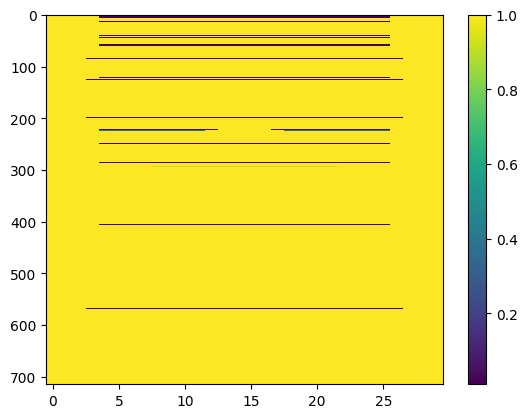

In [9]:
plt.imshow(pv.T, aspect='auto', interpolation='none')
plt.colorbar()
np.min(pv)

In [10]:
hoi_m

array([[1.12408358e-04, 1.37995882e-04, 2.55741916e-04, ...,
        1.61883946e-04, 1.43630739e-04, 1.04880634e-04],
       [9.24721805e-05, 9.63020048e-05, 2.87163637e-04, ...,
        1.90339192e-04, 1.42469322e-04, 6.85381923e-05],
       [2.63094022e-04, 7.80009847e-05, 5.94183310e-04, ...,
        4.37916663e-04, 3.40104914e-05, 1.35885875e-04],
       ...,
       [2.63094022e-04, 7.80009847e-05, 5.94183310e-04, ...,
        4.37916663e-04, 3.40104914e-05, 1.35885875e-04],
       [9.24721805e-05, 9.63020048e-05, 2.87163637e-04, ...,
        1.90339192e-04, 1.42469322e-04, 6.85381923e-05],
       [1.12408358e-04, 1.37995882e-04, 2.55741916e-04, ...,
        1.61883946e-04, 1.43630739e-04, 1.04880634e-04]])

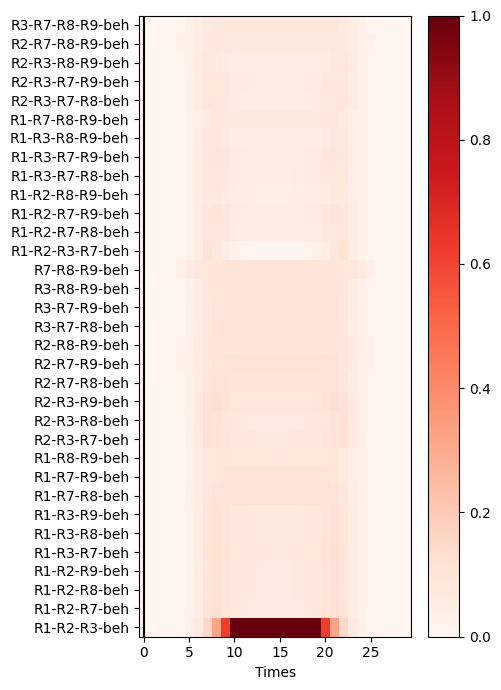

In [55]:

   
vmin, vmax = 0.0,1

list_indices=[]
for m in df.index:
    mm= m.split('-')[:-1]
    list_indices.append(mm)

# the list of indices might be in the form [ ['R1','R2'], ['R2','R3', 'R4'], ['R5', 'R6', 'R7'], ... ]
   
syn_toplot=hoi_m.T*np.where(pv<0.2, 1,0).T
plt.figure(figsize=(5,7))
plt.pcolormesh(
    times, df.index[np.where(np.sum(syn_toplot, axis=1)>0)[0]],syn_toplot[np.where(np.sum(syn_toplot, axis=1)>0)], cmap='Reds', vmin=vmin, vmax=vmax
)
plt.colorbar()
plt.xlabel('Times')
plt.axvline(0., color='k')
plt.tight_layout()
plt.savefig('figure_simulations.png', dpi=600)
plt.show()
plt.close()

In [16]:
df.index

AttributeError: 'function' object has no attribute 'index'

In [ ]:
for isub in range(15):


    beh = np.random.rand()
    n_trials = 500
    n_roi = 12
    n_times = 30

    data = np.zeros((n_roi, n_trials))

    data[0] =  random.normal(loc=0.0, scale=1.0, size=n_trials)
    data[1] =  random.normal(loc=0.0, scale=1.0, size=n_trials)
    data[2] =  random.normal(loc=0.0, scale=1.0, size=n_trials)

    beh = (data[0] + data[1] + data[2])

    data[3] =  random.normal(loc=0.0, scale=1.0, size=n_trials)
    data[4] =  random.normal(loc=0.0, scale=1.0, size=n_trials)
    data[5] = data[3] + data[4]

    data[6] = beh + 3*random.normal(loc=0.0, scale=1.0, size=n_trials)
    data[7] = beh + 3*random.normal(loc=0.0, scale=1.0, size=n_trials)
    data[8] = beh + 3*random.normal(loc=0.0, scale=1.0, size=n_trials)

    data[9] = random.normal(loc=0.0, scale=1.0, size=n_trials)
    data[10] = data[9] + random.normal(loc=0.0, scale=1.0, size=n_trials)
    data[11] = data[9] + random.normal(loc=0.0, scale=1.0, size=n_trials)

    data = data.T

    data_random=np.broadcast_to(np.random.multivariate_normal(np.zeros(12), np.identity(12), n_trials)[:,:,np.newaxis], (n_trials, n_roi, n_times))

    han = np.broadcast_to(np.hanning(n_times), (n_trials, n_roi, n_times))

    data_brain = np.broadcast_to(data[:,:,np.newaxis], (n_trials, n_roi, n_times))* han + (1-han) * data_random

    list_roi=[f"R{r+1}" for r in range(n_roi)]

    roi = np.array(list_roi)
    trials = np.arange(n_trials)
    times = np.arange(n_times)
    
    x = xr.DataArray(data_brain, dims=('trials', 'roi', 'times'),
                        coords=(trials, roi, times))
    
    print("permutation for synergy")
    
    syn = conn_hoi_syn(x, beh, times='times', roi='roi', minsize=minsize, maxsize=maxsize, verbose=None)

    # append
    hoi += [syn]
    # Permuted Red parallel fn
    parallel, p_fun = parallel_func(conn_hoi_syn, n_jobs=-1, total=n_perm)
    # Compute permutations in parallel
    perm = parallel(p_fun(x, np.random.permutation(y), times='times', roi='roi', minsize=minsize, maxsize=maxsize, verbose=None) for n_p in range(n_perm))
    perm = np.stack(perm, axis=0)
    # append
    hoi_p += [perm ]
    # Links names (roi)
    links = syn.roi.data


print('now computing the statistics')
n_links=len(links)

hoi1 = np.array_split(np.stack(hoi), n_links, axis=1)
hoi1_p = np.array_split(np.stack(hoi_p), n_links, axis=2)

# Squeeze
hoi_s = [np.squeeze(val) for val in hoi1]
hoi_p_s = [np.squeeze(val) for val in hoi1_p]
# Reshape
hoi_p_s = [np.swapaxes(val, 0, 1) for val in hoi_p_s]


print("    Compute statistics")

inference='rfx'
mcp='cluster'

wf = WfStats()
pv, tv = wf.fit(hoi_s, hoi_p_s, inference=inference, mcp=mcp, tail=1)
# Mean II across subjects
hoi_m = np.mean(np.stack(hoi_s, axis=0), axis=1).T

# ------------------------------------------------------------------------------------------------------------------
# Save results the file to DataArray
# ------------------------------------------------------------------------------------------------------------------
"""Results_Dir = op.join(db_mne, project, 'group')
fname = op.join(Results_Dir, '{0}_{1}_{2}_{3}_{4}_minorder2.nc'.format(event, mi_reg, mi_type, mcp, hoi_type))
print("    Xarray conversion")
kw_m = dict(dims=('times', 'links'), coords=(times, links))
hoi = xr.DataArray(hoi_m, **kw_m)
pv = xr.DataArray(pv, **kw_m)
tv = xr.DataArray(tv, **kw_m)
data = xr.Dataset({'hoi': hoi, 'pv': pv, 'tv': tv})
data.to_netcdf(fname)
print(fname)"""red = conn_hoi_red(x, beh, times='times', roi='roi', minsize=minsize, maxsize=maxsize, verbose=None) 
    
    # append
    hoi += [red]
    # Permuted Red parallel fn
    parallel, p_fun = parallel_func(conn_hoi_red, n_jobs=-1, total=n_perm)
    # Compute permutations in parallel
    perm = parallel(p_fun(x, np.random.permutation(y), times='times', roi='roi', minsize=minsize, maxsize=maxsize, verbose=None) for n_p in range(n_perm))
    perm = np.stack(perm, axis=0)
    # remove baseline bline from perm
    index_time = np.where((times >= bline[0]) & (times <= bline[1]))[0]
    baseline = perm[:, :, index_time].mean(axis=2)
    std = perm[:, :, index_time].std(axis=2)
    # compute zscore of perm using broadcasting
    perm = (perm - baseline[:, :, np.newaxis]) / std[:, :, np.newaxis]
    # append
    hoi_p += [perm ]
    # Links names (roi)
    links = red.roi.data
    del red
    #we already computed this eh eh 
    #syn = conn_hoi_syn(x_simulated, y=beh , times='times', roi='roi', minsize=minsize, maxsize=maxsize, verbose=None)
    #red = conn_hoi_red(x_simulated, y=beh , times='times', roi='roi', minsize=minsize, maxsize=maxsize, verbose=None)
    

In [83]:
hoi

[<xarray.DataArray 'Red' (roi: 1573, times: 100)>
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]])
 Coordinates:
   * roi      (roi) <U17 'R1-R2' 'R1-R3' ... 'R8-R9-R10-R11-R12'
   * times    (times) int32 0 1 2 3 4 5 6 7 8 9 ... 90 91 92 93 94 95 96 97 98 99,
 <xarray.DataArray 'Syn' (roi: 1573, times: 100)>
 array([[4.72384350e-06, 6.01063336e-06, 6.35101490e-06, ...,
         6.35101490e-06, 6.01063336e-06, 4.72384350e-06],
        [7.72127685e-05, 8.30361496e-05, 8.34916053e-05, ...,
         8.34916053e-05, 8.30361496e-05, 7.72127685e-05],
        [6.34656418e-05, 6.85840015e-05, 6.90669632e-05, ...,
         6.90669632e-05, 6.85840015e-05, 6.34656418e-05],
        ...,
        [1.55297803e-05, 1.55849787e-05, 1.81209543e-05, ...,
         1.81209543

In [74]:
pv, tv = wf.fit(hoi_s, hoi_p_s, inference='rfx', mcp=mcp, tail=1)


AssertionError: 

In [77]:
hoi_s[0][1]

array([4.72384350e-06, 6.01063336e-06, 6.35101490e-06, 6.66024239e-06,
       1.00327585e-05, 7.08096661e-06, 5.83039442e-06, 1.21053893e-05,
       5.76149623e-06, 8.81334496e-06, 2.01667571e-05, 2.20713018e-05,
       2.10133858e-05, 8.05343082e-06, 2.85687579e-07, 8.46003922e-06,
       1.54594226e-05, 1.46720757e-05, 3.01848262e-05, 1.27282165e-04,
       8.87604247e-05, 3.23562487e-05, 9.28329290e-05, 8.32609439e-05,
       8.23320224e-05, 6.10264869e-05, 7.41099570e-05, 5.42429523e-05,
       6.30740113e-05, 9.51875519e-05, 9.71852537e-05, 1.13831259e-04,
       2.06978669e-04, 3.12495777e-04, 3.03219230e-04, 4.67298786e-04,
       4.22788115e-04, 3.76832245e-04, 3.15434754e-04, 2.39565270e-04,
       2.04632805e-04, 1.78227026e-04, 1.33318467e-04, 1.18516296e-04,
       1.16552055e-04, 1.00861963e-04, 8.72666979e-05, 8.76856348e-05,
       9.06366104e-05, 8.76584705e-05, 8.76584705e-05, 9.06366104e-05,
       8.76856348e-05, 8.72666979e-05, 1.00861963e-04, 1.16552055e-04,
      

In [61]:
np.array_split(np.stack(hoi), n_links, axis=1)[0].shape

(2, 1, 100)

In [26]:
hoi1_p = np.array_split(np.stack(hoi_p), n_links, axis=2)

In [32]:
hoi_p_s = [np.squeeze(val) for val in hoi1_p]

In [36]:
hoi_p_s = [np.swapaxes(val, 0, 1) for val in hoi_p_s]


In [39]:
hoi1 = np.array_split(np.stack(hoi), n_links, axis=1)

In [40]:
hoi_s = [np.squeeze(val) for val in hoi1]


In [44]:
wf = WfStats()


Definition of a non-parametric statistical workflow


In [46]:
inference='rfx'
mcp='cluster'

pv, tv = wf.fit(hoi_s, hoi_p_s, inference=inference, mcp=mcp, tail=1)


    T-test across subjects (pop_mean=0.0002933172790331544; center=False; zscore=False; sigma=0.001)
    Cluster forming threshold (tail=1; alpha=0.05; tfce=None)
    Inference at cluster-level
    Cluster detection (threshold=1.1518560995845124; tail=1)


In [52]:
pv.shape

(100, 1573)

In [56]:
hoi_s[0].shape

(2, 100)

## Theoretical background 

The O-information between three Gaussian variables (of variance = 1 ! ) can be computed as follow: 

$$\Omega = \frac{1}{2}log\left( \frac{|\Sigma|}{|\Sigma_{xy}||\Sigma_{xz}||\Sigma_{yz}|}\right)$$

Where $$\Sigma=\begin{pmatrix} 1 & cov(x,y) & cov(x,z) \\ 
cov(x,y) & 1 & cov(y,z) \\
cov(x,z) & cov(y,z) & 1
\end{pmatrix} \ \ \ and \ \ \  \ \Sigma_{a,b}=\begin{pmatrix} 1 & cov(a,b)  \\ 
cov(a,b) & 1 &  
\end{pmatrix} $$

Fixing all the covariances between the gaussian variables we can generate different values of O-information.

Daniele et al work out this model used a parametrization based on factor analysis. In the case of thre variables, they defined the variables in this way: 
$$\begin{cases} 
X=\lambda_x \eta + \theta_x \\
Y=\lambda_y \eta + \theta_y \\
Z=\lambda_z \eta + \theta_z \\
\end{cases}$$

The gaussian variable $\eta$ is generated in such a way that $<\eta>=0$ and $<\eta^2>=1$. So the covariance matrix of our system is:

$$COV= \lambda \lambda^T + \Theta$$

The values of $\theta_{ii}=1-\lambda_i^2$ in order to have just ones on the diagonal of $COV$.

All this work is contained in "An information-theoretic approach to hypergraph psychometrics", Marinazzo et al (2022).

In a similar way it is possible to study a system of four variables of interest. A possible senario would be to have 3 sources (3 brain regions, symptoms, etc.) and 1 target variable (behavioural condition, pathological condition, etc.). The O-information of the 4 gaussian variables (of variance 1) can be computed using the following formula: 

$$\Omega = \frac{1}{2}log\left( \frac{|\Sigma|^2}{|\Sigma_{xyz}||\Sigma_{xzs}||\Sigma_{yzs}||\Sigma_{xys}|}\right)$$

Where $$\Sigma=\begin{pmatrix} 1 & cov(x,y) & cov(x,z) & cov(x,s) \\ 
cov(x,y) & 1 & cov(y,z) & cov(y,s) \\
cov(x,z) & cov(y,z) & 1 & cov(z,s) \\
cov(x,s) & cov(y,s) & cov(z,s) & 1
\end{pmatrix} \ \ \ and \\ \Sigma_{a,b,c}=\begin{pmatrix} 1 & cov(a,b) & cov(a,c) \\ 
cov(b,a) & 1 & cov(b,c) \\
cov(c,a) & cov(c,b) & 1 \end{pmatrix} \\ $$

To test our functions we generate Multivariate gaussian data. Fixing the value of the covariances between the Gaussian variables we can obtain a certain value of O-information (synergy or redundancy). The factor model that we use to generate data is the following.

$$\begin{cases} 
X=\lambda_x \eta + \theta_x \\
Y=\lambda_y \eta + \theta_y \\
Z=\lambda_z \eta + \theta_z \\
S=\lambda_s \eta + \theta_s \\
\end{cases}$$

The gaussian variable $\eta$ is generated in such a way that $<\eta>=0$ and $<\eta^2>=1$. So the covariance matrix of our system is:

$$COV= \lambda \lambda^T + \Theta$$

The values of $\theta_{ii}=1-\lambda_i^2$ in order to have just ones on the diagonal of $COV$.

In [2]:
#defining parameter of our simulation

n_trials=100
n_times=500
n_roi=12
time_bump=[100,200,300,400]
time_length_bump=[100,100,100,100]
triplet_character=['redundancy', 'synergy', 'redundancy', 'synergy']
triplet_character_with_beh=['redundancy', 'synergy', 'null', 'null']

simulated_data, beh = simulation_hois.simul_hois(target = False, 
                                                 target_frites=True,                                                                             
                                                 n_nodes=n_roi, 
                                                 n_times=n_times, 
                                                 n_trials=n_trials, 
                                                 time_bump=time_bump,
                                                 triplet_character_with_beh=['redundancy', 'synergy', 'null', 'null'],
                                                 triplet_character=triplet_character,
                                                 time_length_bump=time_length_bump,                                            
                                                 )




'''sim=np.zeros((n_trials, n_roi, 30))
for i in range(30):

    sim[:,:,i]=simulated_data_without_target

simulated_data_without_target=sim'''

# In this provisional tutorial we work with xarray. We are flexible -> the data is generated as numpy 
list_roi=[f"R{r+1}" for r in range(n_roi)]
roi = np.array(list_roi)
trials = np.arange(n_trials)
times = np.arange(n_times)

#the data on which the oinfo is computed is given in the shape of an xarray
x_simulated = xr.DataArray(simulated_data, dims=('trials', 'roi', 'times'),
                     coords=(trials, roi, times))

roi_plus_beh = list_roi
roi_plus_beh.append('beh')
roi_plus_beh= np.array(roi_plus_beh)

x_sim = xr.DataArray(np.concatenate((simulated_data, np.repeat(beh[:,np.newaxis,np.newaxis], n_times, axis=2)), axis = 1), dims=('trials', 'roi', 'times'),
                     coords=(trials, roi_plus_beh, times))

maxsize=3
minsize=2

oinfo_without_beh = conn_hoi_oinfo(x_simulated, y=None , times='times', roi='roi', minsize=minsize, maxsize=maxsize, verbose=None)
oinfo = conn_hoi_oinfo(x_simulated, y=beh, times='times', roi='roi', minsize=minsize, maxsize=maxsize, verbose=None)
oinfo_all_together = conn_hoi_oinfo(x_sim ,y=None , times='times', roi='roi', minsize=minsize, maxsize=maxsize, verbose=None)
syn = conn_hoi_syn(x_simulated, y=beh , times='times', roi='roi', minsize=minsize, maxsize=maxsize, verbose=None)
red = conn_hoi_red(x_simulated, y=beh , times='times', roi='roi', minsize=minsize, maxsize=maxsize, verbose=None)



c:\users\matte\new_codes\xfrites\xfrites\simulations\simulation_hois.py:247: RuntimeWarning: covariance is not positive-semidefinite.
  sim_static_hois = np.random.multivariate_normal(mean_mvgauss, cov=cov_al, size=n_trials, check_valid='warn', tol=1e-8)
Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi names


  0%|          |  : 0/286 [00:00<?,       ?it/s]

Compute the  HOI (min=2; max=3)
    Copnorm the data
    Multiplets of size 2
    Multiplets of size 3
Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi names


  0%|          |  : 0/286 [00:00<?,       ?it/s]

Compute the task-related  HOI (min=2; max=3)
    Copnorm the data
    Multiplets of size 2
    Multiplets of size 3
Defining links (n_roi=13; directed=False; net=False, nb_min_links=None)
    Sorting roi names


  0%|          |  : 0/364 [00:00<?,       ?it/s]

Compute the  HOI (min=2; max=3)
    Copnorm the data
    Multiplets of size 2
    Multiplets of size 3
Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi names
Compute HOI synergy(min=2; max=3)
    Copnorm the data
    Apply the Gaussian Copula Rank Normalization
    Multiplets of size 2
    Multiplets of size 3
Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi names
Compute HOI redundancy(min=2; max=3)
    Copnorm the data
    Apply the Gaussian Copula Rank Normalization
    Multiplets of size 2
    Multiplets of size 3


In [3]:
theta_zs=0.1
L = np.array([1, 2, 3, 4])[np.newaxis]
np.diagflat(1 - L**2)+np.diagflat([0, 0, theta_zs], 1) + np.diagflat([0, 0, theta_zs], -1) +L[np.newaxis]*L[np.newaxis].T



array([[[  1. ,   2. ,   3. ,   4. ],
        [  1. ,  -1. ,   3. ,   4. ],
        [  1. ,   2. ,  -5. ,   4.1],
        [  1. ,   2. ,   3.1, -11. ]],

       [[  2. ,   4. ,   6. ,   8. ],
        [  2. ,   1. ,   6. ,   8. ],
        [  2. ,   4. ,  -2. ,   8.1],
        [  2. ,   4. ,   6.1,  -7. ]],

       [[  3. ,   6. ,   9. ,  12. ],
        [  3. ,   3. ,   9. ,  12. ],
        [  3. ,   6. ,   1. ,  12.1],
        [  3. ,   6. ,   9.1,  -3. ]],

       [[  4. ,   8. ,  12. ,  16. ],
        [  4. ,   5. ,  12. ,  16. ],
        [  4. ,   8. ,   4. ,  16.1],
        [  4. ,   8. ,  12.1,   1. ]]])

## A possible way to deal with higher-order spreading of O-information

In [4]:
oi = oinfo_without_beh.to_pandas()

In [5]:
# I left the following functions in the example notebook, to let everybody see how is it working, in a second moment it could be integrated in the other functions

def oinfo_min(oinfo_array, list_indices):

    n_times=oinfo_array.shape[1]
    oi_array=oinfo_array.copy()


    for n,m in enumerate(list_indices):

        if len(m)>=4:

            sub_ind = []
            for sub_m in combinations(m, len(m)-1):
                sub_ind.append(list_indices.index(list(sub_m)))
            
            for t in range(n_times):
                diff_oi =[]
                count=0

                for sub_i in sub_ind:
                    count += np.sign(oinfo_array[n,t]-oinfo_array[sub_i,t])
                    diff_oi.append(abs(oinfo_array[n,t]-oinfo_array[sub_i,t]))
                if int(np.abs(count))==len(m):

                    oi_array[n,t] = min(diff_oi)*np.sign(count)
                
                else:
                    oi_array[n,t]=0
    return oi_array

In [6]:

oi_array = np.array(oinfo)

list_indices=[]
for m in oi.index:
    mm= m.split('-')
    list_indices.append(mm)

# the list of indices might be in the form [ ['R1','R2'], ['R2','R3', 'R4'], ['R5', 'R6', 'R7'], ... ]
oi_array = oinfo_min(oi_array,list_indices)
           


In [7]:
oi_array = np.array(oinfo)-np.array(oinfo_without_beh)


In [8]:
oi_array.shape

(286, 500)

## Plotting the result of Oinfo

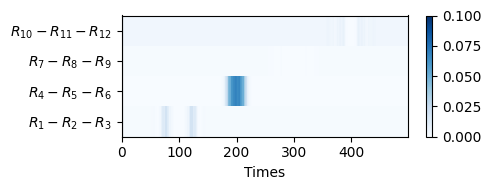

In [13]:
vmin, vmax = 0,0.1
minmax = max(abs(vmin), abs(vmax))
vmin, vmax = vmin, vmax
df = syn.to_pandas()

#oin = oinfo - oinfo_without_beh
#ind_to_plot=[np.where(df.index=='R1-R2-R3-beh')[0][0], np.where(df.index=='R4-R5-R6-beh')[0][0],np.where(df.index=='R7-R8-R9-beh')[0][0],np.where(df.index=='R10-R11-R12-beh')[0][0]]
ind_to_plotwbeh=[np.where(df.index=='R1-R2-R3')[0][0], np.where(df.index=='R4-R5-R6')[0][0],np.where(df.index=='R7-R8-R9')[0][0],np.where(df.index=='R10-R11-R12')[0][0]]
ind_to_plot=ind_to_plotwbeh
# plot the results
plt.figure(figsize=(5,2))
plt.pcolormesh(
    df.columns, ['$R_1-R_2-R_3$', '$R_4-R_5-R_6$', '$R_7-R_8-R_9$', '$R_{10}-R_{11}-R_{12}$'], df.values[ind_to_plot,:], cmap='Blues', vmin=vmin, vmax=vmax
)
plt.colorbar()
plt.xlabel('Times')
plt.axvline(0., color='k')
plt.tight_layout()
plt.savefig('figure_simulations_syn.png', dpi=600)
plt.show()
plt.close()

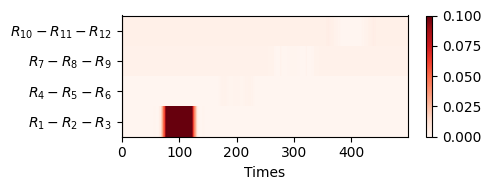

In [14]:
vmin, vmax = 0,0.1
minmax = max(abs(vmin), abs(vmax))
vmin, vmax = vmin, vmax
df = red.to_pandas()

#oin = oinfo - oinfo_without_beh
#ind_to_plot=[np.where(df.index=='R1-R2-R3-beh')[0][0], np.where(df.index=='R4-R5-R6-beh')[0][0],np.where(df.index=='R7-R8-R9-beh')[0][0],np.where(df.index=='R10-R11-R12-beh')[0][0]]
ind_to_plotwbeh=[np.where(df.index=='R1-R2-R3')[0][0], np.where(df.index=='R4-R5-R6')[0][0],np.where(df.index=='R7-R8-R9')[0][0],np.where(df.index=='R10-R11-R12')[0][0]]
ind_to_plot=ind_to_plotwbeh
# plot the results
plt.figure(figsize=(5,2))
plt.pcolormesh(
    df.columns, ['$R_1-R_2-R_3$', '$R_4-R_5-R_6$', '$R_7-R_8-R_9$', '$R_{10}-R_{11}-R_{12}$'], df.values[ind_to_plot,:], cmap='Reds', vmin=vmin, vmax=vmax
)
plt.colorbar()
plt.xlabel('Times')
plt.axvline(0., color='k')
plt.tight_layout()
plt.savefig('figure_simulations_red.png', dpi=600)
plt.show()
plt.close()

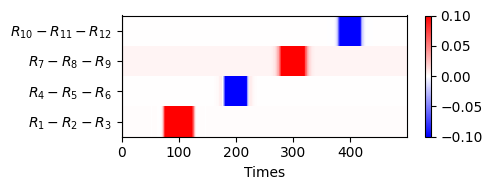

In [15]:
vmin, vmax = -0.1,0.1
minmax = max(abs(vmin), abs(vmax))
vmin, vmax = vmin, vmax
df = oinfo.to_pandas()

#oin = oinfo - oinfo_without_beh
ind_to_plot=[np.where(df.index=='R1-R2-R3-beh')[0][0], np.where(df.index=='R4-R5-R6-beh')[0][0],np.where(df.index=='R7-R8-R9-beh')[0][0],np.where(df.index=='R10-R11-R12-beh')[0][0]]
#ind_to_plotwbeh=[np.where(df.index=='R1-R2-R3')[0][0], np.where(df.index=='R4-R5-R6')[0][0],np.where(df.index=='R7-R8-R9')[0][0],np.where(df.index=='R10-R11-R12')[0][0]]
#ind_to_plot=ind_to_plotwbeh
# plot the results
plt.figure(figsize=(5,2))
plt.pcolormesh(
    df.columns, ['$R_1-R_2-R_3$', '$R_4-R_5-R_6$', '$R_7-R_8-R_9$', '$R_{10}-R_{11}-R_{12}$'], df.values[ind_to_plot,:], cmap='bwr', vmin=vmin, vmax=vmax
)
plt.colorbar()
plt.xlabel('Times')
plt.axvline(0., color='k')
plt.tight_layout()
plt.savefig('figure_simulations_oinfo.png', dpi=600)
plt.show()
plt.close()

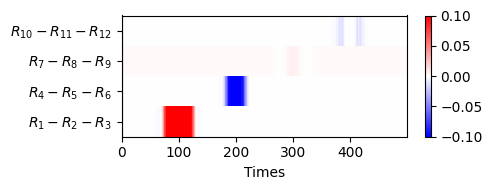

In [16]:
vmin, vmax = -0.1,0.1
minmax = max(abs(vmin), abs(vmax))
vmin, vmax = vmin, vmax
df_array = oinfo.to_pandas().values-oinfo_without_beh.to_pandas().values

#oin = oinfo - oinfo_without_beh
ind_to_plot=[np.where(df.index=='R1-R2-R3-beh')[0][0], np.where(df.index=='R4-R5-R6-beh')[0][0],np.where(df.index=='R7-R8-R9-beh')[0][0],np.where(df.index=='R10-R11-R12-beh')[0][0]]
#ind_to_plotwbeh=[np.where(df.index=='R1-R2-R3')[0][0], np.where(df.index=='R4-R5-R6')[0][0],np.where(df.index=='R7-R8-R9')[0][0],np.where(df.index=='R10-R11-R12')[0][0]]
#ind_to_plot=ind_to_plotwbeh
# plot the results
plt.figure(figsize=(5,2))
plt.pcolormesh(
    df.columns, ['$R_1-R_2-R_3$', '$R_4-R_5-R_6$', '$R_7-R_8-R_9$', '$R_{10}-R_{11}-R_{12}$'], df_array[ind_to_plot,:], cmap='bwr', vmin=vmin, vmax=vmax
)
plt.colorbar()
plt.xlabel('Times')
plt.axvline(0., color='k')
plt.tight_layout()
plt.savefig('figure_simulations_gradientoinfo.png', dpi=600)
plt.show()
plt.close()

In [11]:
simulated_data, beh

(array([[[-0.66241708, -0.66241708, -0.66241708, ..., -0.66241708,
          -0.66241708, -0.66241708],
         [-0.90508346, -0.90508346, -0.90508346, ..., -0.90508346,
          -0.90508346, -0.90508346],
         [ 2.15137872,  2.15137872,  2.15137872, ...,  2.15137872,
           2.15137872,  2.15137872],
         ...,
         [-0.20071523, -0.20071523, -0.20071523, ..., -0.20071523,
          -0.20071523, -0.20071523],
         [ 0.36415103,  0.36415103,  0.36415103, ...,  0.36415103,
           0.36415103,  0.36415103],
         [ 0.70122283,  0.70122283,  0.70122283, ...,  0.70122283,
           0.70122283,  0.70122283]],
 
        [[ 0.67181867,  0.67181867,  0.67181867, ...,  0.67181867,
           0.67181867,  0.67181867],
         [-0.37233323, -0.37233323, -0.37233323, ..., -0.37233323,
          -0.37233323, -0.37233323],
         [ 0.96542337,  0.96542337,  0.96542337, ...,  0.96542337,
           0.96542337,  0.96542337],
         ...,
         [ 0.69580879,  0.6958087

In [11]:
ind_to_plot[0][0]

NameError: name 'ind_to_plot' is not defined

In [ ]:
np.where(df.index=='R1-R2-R3-beh')[0]


array([66], dtype=int64)

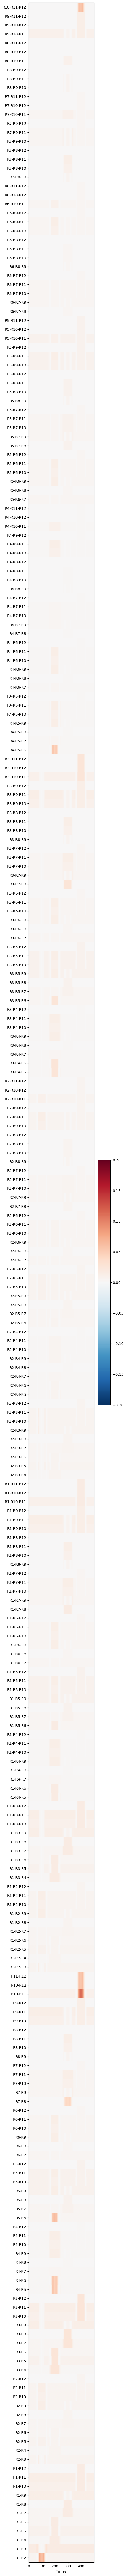

In [22]:
vmin, vmax = -0.2,0.2
minmax = max(abs(vmin), abs(vmax))
vmin, vmax = -minmax, minmax

#oin = oinfo - oinfo_without_beh

# plot the results
df = red.to_pandas()
plt.figure(figsize=(5,100))
plt.pcolormesh(
    df.columns, df.index, df.values, cmap='RdBu_r', vmin=vmin, vmax=vmax
)
plt.colorbar()
plt.xlabel('Times')
plt.axvline(0., color='k')
plt.tight_layout()
plt.savefig('figure_simulations.png', dpi=600)
plt.show()
plt.close()

# Plotting results Oinfo clean

In [6]:
vmin, vmax = -0.2,0.2
minmax = max(abs(vmin), abs(vmax))
vmin, vmax = -minmax, minmax

#oin = oinfo - oinfo_without_beh

# plot the results
df = oinfo.to_pandas()
plt.figure(figsize=(5,100))
plt.pcolormesh(
    df.columns, df.index, oi_array, cmap='RdBu_r', vmin=vmin, vmax=vmax
)
plt.colorbar()
plt.xlabel('Times')
plt.axvline(0., color='k')
plt.tight_layout()
plt.savefig('figure_simulations.png', dpi=600)
plt.show()
plt.close()

NameError: name 'oi_array' is not defined

<Figure size 500x10000 with 0 Axes>

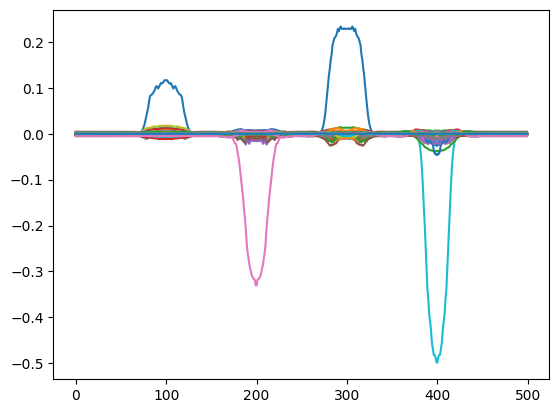

In [26]:
data_numpy=oi_array
for i in range(len(data_numpy)):
    plt.plot(data_numpy[i])
plt.show()
plt.close()